In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from scipy.fft import fft, fftfreq
import scipy.signal as sig
from sklearn import linear_model

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import util

%matplotlib inline

## Set matplotlib

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

def get_results(testcase, config, runs):
    modelname = "AN"
    path = f"../run/main/{testcase}/model{modelname}/{config}"
    ds = ndsv.Dataset.from_file(f"../run/main/{testcase}/dataset.npz")
    run = util.select_run(testcase, modelname, config, runs)    
    surr   = ndsv.GeneratedData.from_file(f"../run/main/{testcase}/surrogates.npz")
    sims   = ndsv.GeneratedData.from_file(f"{path}/run{run:02d}/simulations.npz")
    params = ndsv.Params.from_file(f"{path}/run{run:02d}/parameters.npz")
        
    return dotdict(ds=ds, sims=sims, params=params, surr=surr)

res = get_results("hopf", "ns_2_mreg_2_msub_1_nf_32", [0,1])

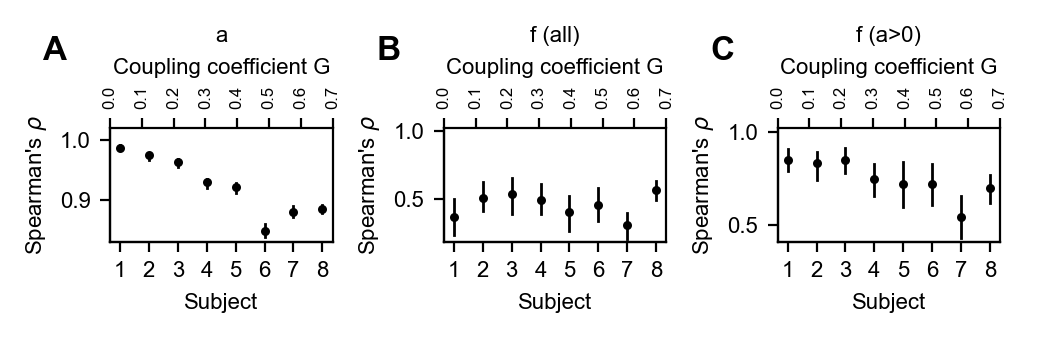

In [4]:
def plot_ci(pos, x, q, color='k', ls='-', zorder=None):
    plt.plot([pos,pos], np.nanpercentile(x, q), lw=1, color=color, ls=ls, zorder=zorder)
    plt.scatter(pos, np.nanmedian(x), color=color, s=5, zorder=zorder)


def get_rhos(ptru, pest, nsamples, linreg=None):
    """
    ptru ... Ground truth, shape (n,)
    pest ... Estimated parameters (Gaussians, mu and std in last dimension), shape (n, m, 2)
    n = number of parameters, m = dimensionality of the estimated parameter space
    
    Returns array of shape (nsamples) with Spearman's rho
    """
    
    if not linreg:
        linreg = linear_model.LinearRegression().fit(pest[:,:,0], ptru)
    
    rhos = np.zeros(nsamples)
    for i in range(nsamples):
        pest_samples = np.random.normal(pest[:,:,0], pest[:,:,1])
        pest_samples_projected = linreg.predict(pest_samples)
                        
        rhos[i] = stats.spearmanr(ptru, pest_samples_projected)[0]
                
    return rhos  

def plot_paramfit(ax, ptru, pest, mask=None, nsamples=100, title=None, gs=None):
    nsub, nreg, m, _ = pest.shape
    assert ptru.shape == (nsub, nreg)
    
    if mask is not None:
        assert mask.shape == (nsub, nreg)
    else:
        mask = np.ones(ptru.shape, dtype=bool)

    plt.sca(ax)
    if title:
        plt.title(title)
    
    # Linear regression on all samples
    linreg = linear_model.LinearRegression().fit(pest[mask][:,:,0], ptru[mask])
    
    for i in range(nsub):
        rhos = get_rhos(ptru[i, mask[i]], pest[i, mask[i]], nsamples, linreg)
        plot_ci(i, rhos, [5,95])
        
    plot.axbottomleft(ax)
    plt.ylabel(r"Spearman's $\rho$")
    # plt.ylim(-0.05, 1.05)        
    plt.ylim(top=1.02)
    plt.xlabel("Subject")
    plt.xticks(np.r_[:nsub], np.r_[:nsub]+1)
    
    if gs is not None:
        plt.twiny()
        plt.xticks(np.r_[:nsub], gs, fontsize=6, rotation='vertical')
        plt.xlabel("Coupling coefficient G")
    
    
fig = plt.figure(figsize=(5, 1.5), dpi=200)    

gs = GridSpec(1, 3, left=0.09, right=0.98, top=0.64, bottom=0.26, wspace=0.5)

glabels = [f"{g:3.1f}" for g in res.ds.thetasub[:,0]]


ax0 = plt.subplot(gs[0])
plot_paramfit(ax0, res.ds.thetareg[:,:,0], res.params.thetareg, title="a", gs=glabels)

ax1 = plt.subplot(gs[1])
plot_paramfit(ax1, res.ds.thetareg[:,:,1], res.params.thetareg, title="f (all)", gs=glabels)

ax2 = plt.subplot(gs[2])
plot_paramfit(ax2, res.ds.thetareg[:,:,1], res.params.thetareg, mask=res.ds.thetareg[:,:,0] > 0,
              title="f (a>0)", gs=glabels)

bg = plot.Background(visible=False)
plot.add_panel_letters(fig, axes=[ax0, ax1, ax2], fontsize=12, xpos=-0.3, ypos=1.6)
plt.savefig("./img/Fig_HopfParamRecovery.pdf")

In [5]:
res.ds.thetareg.shape, res.params.thetareg.shape

((8, 68, 2), (8, 68, 2, 2))